### Import dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt

### Merge dataset

In [2]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [3]:
stock_filepath = '../../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../../data/scraping/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋

C:\Users\songkyu\AppData\Local\Temp\ipykernel_19296\3770461931.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_fillna[column].fillna(method='ffill',inplace=True)


### Choose dataset & Hyperparameter setting

In [4]:
data, dataname = stock_df, 'stock_df' # stock_df / total_df
TARGET = "1d_ROC"                      # "Close" / "1d_ROC"
SEQ_SIZE = 30                         # 30 / 60 / 120
PRED_SIZE = 10
BATCH_SIZE = 1                        # 1 / 4 / 8
HIDDEN_SIZE = 64                      # 64 / 128
EPOCHS = 1000

In [5]:
data.index = data["Date"]
data.drop(columns = "Date", inplace = True)
data["PINS"].fillna(24.99, inplace = True)
data

,Open,Close,High,Low,Volume,1d_ROC,5d_ROC,5MA,120MA,bol_high,...,DPO,KST,STC,RSI,SRSI,UO,MFI,SPOT,PINS,FB
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,259.28,267.66,269.75,256.58,11642148,0.000000,14.443304,260.128,325.000667,286.872017,...,2.1680,-88.281564,44.762606,45.523889,0.384404,48.377492,44.377291,135.68,24.99,113.74
2019-01-03,270.20,271.20,275.79,264.43,14954204,1.322573,6.910553,263.634,323.962333,286.339561,...,-1.6655,-86.593692,64.779342,45.949547,0.424055,49.951722,46.086376,131.74,24.99,109.02
2019-01-04,281.88,297.57,297.80,278.54,19309374,9.723451,16.433854,272.034,323.104750,291.444515,...,5.3625,-75.831614,79.644575,48.970092,0.705424,53.480333,46.642910,137.95,24.99,118.51
2019-01-07,302.10,315.34,316.80,301.65,18598132,5.971704,23.141206,283.886,322.570250,300.275444,...,-0.4305,-56.832386,89.822288,50.852293,0.880754,56.283542,48.992941,138.05,24.99,119.36
2019-01-08,319.98,320.27,320.59,308.01,15324452,1.563392,19.655533,294.408,322.113083,310.280492,...,-9.3770,-28.087969,94.911144,51.358475,0.927906,59.329800,51.038876,142.53,24.99,117.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,494.00,486.76,496.02,485.45,2702672,-0.986554,3.114011,489.756,428.004000,500.053490,...,-19.5075,65.080263,94.696173,58.277287,0.909965,52.260244,63.797634,353.39,37.38,189.59
2023-12-26,489.39,491.19,491.48,486.38,2032683,0.910099,1.042952,490.770,428.440250,501.759236,...,-18.3485,67.068382,97.348086,58.776649,0.941589,54.393804,63.632425,354.83,37.16,189.88
2023-12-27,491.24,491.79,494.02,489.25,2559832,0.122152,-0.652499,490.124,428.887667,503.497049,...,-12.8580,69.341178,98.674043,58.844494,0.945886,53.844831,63.654456,357.83,37.30,190.27


### Make train datset

In [6]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0,:],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

[[259.28 267.66 269.75 ... 135.68  24.99 113.74]
 [270.2  271.2  275.79 ... 131.74  24.99 109.02]
 [281.88 297.57 297.8  ... 137.95  24.99 118.51]
 ...
 [350.   345.73 352.87 ... 165.79  24.99 137.82]
 [348.09 359.97 360.   ... 165.04  24.99 140.46]
 [357.3  351.77 359.6  ... 164.07  24.99 143.54]] 
 [ 2.0752196  -0.6126939   1.41508112 -0.55537135 -0.81687088  1.69482029
  0.24516556  0.29128081 -0.57538976 -1.31452035]
X size :  (1218, 30, 37)
y size :  (1218, 10)


### Define X_test

In [7]:
X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])
print(X_test)
print("X_test size : ", X_test.shape)

[[[463.   466.95 467.28 ... 334.19  31.27 175.28]
  [466.95 465.91 467.65 ... 335.04  31.49 176.05]
  [465.4  474.47 476.76 ... 339.97  32.13 179.86]
  ...
  [491.24 491.79 494.02 ... 357.83  37.3  190.27]
  [492.   490.51 492.89 ... 358.32  37.27 188.75]
  [490.37 486.88 492.23 ... 353.96  37.04 187.91]]]
X_test size :  (1, 30, 37)


### Standardization

In [8]:
from sklearn.preprocessing import StandardScaler

X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

print("X size : ", X.shape)
print("X_test size : ", X_test.shape)

X size :  (1218, 30, 37)
X_test size :  (1, 30, 37)


### Split train-validation dataset

In [9]:
# to DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

# to tensor
X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

# to DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

### Modeling

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

class LSTMModel(nn.Module):
    def __init__(self,input_dim):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size = HIDDEN_SIZE, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(HIDDEN_SIZE, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, PRED_SIZE)
                                )

    def forward(self,x):
        x,_ = self.lstm(x)
#         print('output of lstm :',x.size()) # torch.Size([1, 120, 64])
        x = self.dropout(x[:,-1,:])
#         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
        x = self.seq(x)
        return x

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [11]:
model = LSTMModel(X_train.shape[2])
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 20, verbose = True)

### RUN!!

In [12]:
epoch_counter = 0
patience = 30
best_loss = float('inf')
done = False
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<EPOCHS:
    epoch_counter+=1

    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler.step(val_loss)

    if es(model, val_loss):
        done = True

    if val_loss < best_loss:
        best_loss = val_loss
        
    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 2.5586, Validation Loss: 2.3558
Epoch 2/1000, Train Loss: 2.5519, Validation Loss: 2.3499
Epoch 3/1000, Train Loss: 2.5387, Validation Loss: 2.3298
Epoch 4/1000, Train Loss: 2.5201, Validation Loss: 2.3472
Epoch 5/1000, Train Loss: 2.5053, Validation Loss: 2.3134
Epoch 6/1000, Train Loss: 2.4886, Validation Loss: 2.3045
Epoch 7/1000, Train Loss: 2.4786, Validation Loss: 2.2878
Epoch 8/1000, Train Loss: 2.4757, Validation Loss: 2.2857
Epoch 9/1000, Train Loss: 2.4653, Validation Loss: 2.2694
Epoch 10/1000, Train Loss: 2.4608, Validation Loss: 2.2656
Epoch 11/1000, Train Loss: 2.4591, Validation Loss: 2.2632
Epoch 12/1000, Train Loss: 2.4580, Validation Loss: 2.2709
Epoch 13/1000, Train Loss: 2.4556, Validation Loss: 2.2635
Epoch 14/1000, Train Loss: 2.4537, Validation Loss: 2.2558
Epoch 15/1000, Train Loss: 2.4521, Validation Loss: 2.2573
Epoch 16/1000, Train Loss: 2.4493, Validation Loss: 2.2574
Epoch 17/1000, Train Loss: 2.4499, Validation Loss: 2.2540
Epoch 

In [13]:
print(f"Best validation loss : {best_loss}")

Best validation loss : 2.127498202636594


### Visualize train-validation loss

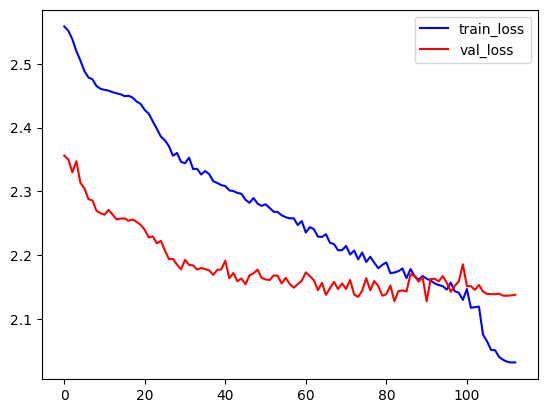

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

### Prediction

In [15]:
# evaluation
model.eval()
with torch.no_grad():
    X_test = torch.tensor(X_test.astype(np.float32), dtype = torch.float32)
    pred = model(X_test)

pred = pred.detach().numpy()
print(pred)

[[-0.951155   -0.75250214 -0.52194357 -0.23649943  0.08887908  0.12490591
   0.2609663   0.59479535  0.80387825  0.736284  ]]


In [16]:
if TARGET == "1d_ROC" :
    endPrice = data['Close'].iloc[-1]
    pred_close = []

    for i in pred[0] :
        endPrice = endPrice + endPrice*0.01*i
        pred_close.append(endPrice)

    pred = np.array(pred_close).reshape(1, PRED_SIZE)
    pred
else :
    pass

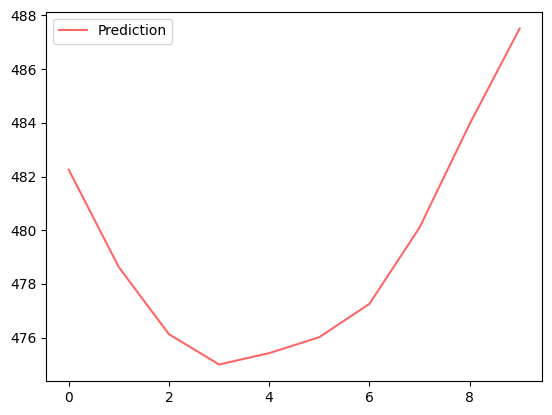

In [17]:
pred_length = len(np.reshape(pred, (-1)))
pred_indices = list(range(pred_length))
plt.plot(pred_indices, np.reshape(pred, (-1)), color='red', alpha=0.6, label='Prediction')
plt.legend()

plt.show()

### Evaluation

In [18]:
# # Label
# label = pd.read_csv('2024_JAN.csv') # 각자 test.csv 파일 경로
# label = np.array(label.head(PRED_SIZE)["Close Price"])

# # Prediction
# pred = np.array(pred).reshape(PRED_SIZE)

# # 날짜 데이터
# period = pd.read_csv('2024_JAN.csv')["Date"]
# period = [d for d in period.head(PRED_SIZE)]

# # 오차율 계산
# error_rate = np.abs((label - pred) / label) * 100

# # 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(period, label, marker='o', color='blue', label='Actual Close Price')
# plt.plot(period, pred, marker='x', color='red', linestyle='--', label='Predicted Close Price')

# # 오차율을 각 포인트에 텍스트로 표시
# for date, lbl, prd, err in zip(period, label, pred, error_rate):
#     plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# plt.xticks(rotation = 45)  # 날짜 레이블 회전
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.title(f'model = LSTM, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
# plt.legend()
# plt.tight_layout()  # 레이아웃 조정
# plt.show()

# # 오차율을 출력
# error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

In [19]:
# # 평균 오차율 계산
# average_error_rate = np.mean(error_rate)

# print(f"Average Error Rate: {average_error_rate:.2f}%")

## 이거 그대로 스크롤해서 result 엑셀에 붙여넣기!!

In [20]:
for price in pred :
    print(price)

[482.2490165  478.62008232 476.12195558 474.99592987 475.41810188
 476.0119272  477.25415792 480.09284344 483.95220538 487.51546812]
